**MO-BOLFI**

The notebook presents an implementation of Multi-objective BOLFI algorithm (arxiv link)
The dataset used is self-collected data for psychology analysis in decision-making (description here).
Feel free to contact e1039688@u.nus.edu if you have any question regarding the paper and the codes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from scipy.optimize import minimize
import os

In [2]:
# Load response and attributes data
# In synthetic data example we'll only use attributes data for further simulation
df = pd.read_csv("et_choice_resultf5.csv")

**Data Preprocessing**

We use all the A and S scenarios. There are 320 observations in the scenarios we use. Each observation represents a candidate answered a question "Which one would you like to choose?" under A1.1 from 3 alternatives (denoted as 1, 3, 4 respectively in raw data), given 3 attributes values for each alternative. The final choice made and fixation trail of each candidate are recorded.


3 attributes:

RC - Renting cost (per month)

OC - Operating cost (per day)

DR - Driving range


The outcome from candidates are fixation_trail and choice. Fixation_trail is the aggregated time of fixation during the scenario. The choice is the final chosen alternative of the candidate.

In [3]:
# define hyper params
number_of_alternatives = 3
number_of_attributes = 3
number_of_discrepancies = 2 # two data sources, resposne time and choices made

In [4]:
# We select scenarios with letter "A" and "S", these scenarios are designed to learn different psychcology affects.
# Different scenarios give different attributes values to alternatives, we consider all the scenarios for Attraction ("A") affect and Significance ("S") affect
df_data = df[df.Scenario == "A1.1"]
df_data = pd.concat([df_data, df[df.Scenario == "A1.1R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.2"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.2R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.3"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.3R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.4"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.4R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S1.1"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S1.1R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S1.2"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S1.2R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S1.3"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S1.3R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S1.4"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S1.4R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S2.1"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S2.1R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S2.2"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S2.2R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S2.3"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S2.3R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S2.4"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "S2.4R"]],axis=0)



# Standardize attributes data
# There are 3 attributes RC OC DR CT
# Response time column: fixation trail
X_attributes = df_data[["RC","OC","DR"]].astype("float64")
X_attributes[["DR"]] = np.log(X_attributes[["DR"]])
X_attributes = (X_attributes-0)/(X_attributes.max()-0) # don't use classic standardization because DR column is discrete with large values (large variance)

# RC, OC are expected to be small, DR is expected to be large
# Transform the columns RC OC to unify the direction of optimization
X_attributes[["RC"]] = 1 - X_attributes[["RC"]]
X_attributes[["OC"]] = 1 - X_attributes[["OC"]]
X_attributes[["DR"]] = 1 - X_attributes[["DR"]]


X_attributes = pd.DataFrame(X_attributes.values.reshape(X_attributes.shape[0]//number_of_alternatives, number_of_attributes*number_of_alternatives),
                    columns=['RC1', 'OC1', 'DR1', 'RC3', 'OC3', 'DR3', 'RC4', 'OC4', 'DR4']) # set index by ID and reset_index for a new column



In [5]:
X_attributes

,RC1,OC1,DR1,RC3,OC3,DR3,RC4,OC4,DR4
0,0.752066,0.631068,0.086409,0.826446,0.864078,0.161504,0.834711,0.864078,0.221110
1,0.652893,0.650485,0.017315,0.652893,0.805825,0.086409,0.661157,0.805825,0.119212
2,0.752066,0.728155,0.072398,0.702479,0.893204,0.138843,0.710744,0.893204,0.188306
3,0.652893,0.631068,0.008403,0.652893,0.834951,0.086409,0.661157,0.834951,0.119212
4,0.652893,0.572816,0.026803,0.636364,0.834951,0.101898,0.644628,0.834951,0.138843
...,...,...,...,...,...,...,...,...,...
315,0.752066,0.679612,0.059606,0.677686,0.864078,0.138843,0.710744,0.825243,0.138843
316,0.553719,0.757282,0.059606,0.462810,0.893204,0.138843,0.495868,0.854369,0.138843
317,0.256198,0.368932,0.072398,0.033058,0.834951,0.138843,0.066116,0.796117,0.138843
318,0.652893,0.504854,0.036945,0.545455,0.805825,0.119212,0.578512,0.766990,0.119212


In [6]:
# The response data, this data will not be used in this experiment, but the "real data" we use below should have same structure
X_response = df_data[["ID","alt","chosen","fixation_trail"]]
# Change milsecond to second
X_response[["fixation_trail"]] = X_response[["fixation_trail"]]/1000

X_response["chosen1"] = 1*(X_response['chosen']==1)*(X_response["alt"]==1)
X_response["chosen3"] = 1*(X_response['chosen']==1)*(X_response["alt"]==3)
X_response["chosen4"] = 1*(X_response['chosen']==1)*(X_response["alt"]==4)


X_response = X_response.drop(columns=["alt","chosen"])

condition_chosen = X_response[(X_response['chosen1']==0) & (X_response['chosen3']==0) & (X_response['chosen4']==0)].index
X_response = X_response.drop(condition_chosen)

C:\Users\euijin\AppData\Local\Temp\ipykernel_57820\1075131055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_response[["fixation_trail"]] = X_response[["fixation_trail"]]/1000
C:\Users\euijin\AppData\Local\Temp\ipykernel_57820\1075131055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_response["chosen1"] = 1*(X_response['chosen']==1)*(X_response["alt"]==1)
C:\Users\euijin\AppData\Local\Temp\ipykernel_57820\1075131055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [7]:
X_response.head()

,ID,fixation_trail,chosen1,chosen3,chosen4
96,111671,12.508,0,1,0
284,11199,18.318,1,0,0
469,111912,6.924,1,0,0
664,112015,6.608,1,0,0
905,112119,18.100,1,0,0


In [8]:
X_attributes.head()

,RC1,OC1,DR1,RC3,OC3,DR3,RC4,OC4,DR4
0,0.752066,0.631068,0.086409,0.826446,0.864078,0.161504,0.834711,0.864078,0.221110
1,0.652893,0.650485,0.017315,0.652893,0.805825,0.086409,0.661157,0.805825,0.119212
2,0.752066,0.728155,0.072398,0.702479,0.893204,0.138843,0.710744,0.893204,0.188306
3,0.652893,0.631068,0.008403,0.652893,0.834951,0.086409,0.661157,0.834951,0.119212
4,0.652893,0.572816,0.026803,0.636364,0.834951,0.101898,0.644628,0.834951,0.138843


**MLBA Simulator**

This section defines a simulator model that generates outcomes (fixation_trail, choice) given a set of parameter values and attributes data. The model refers to *[Hancock et al, 2021](https://www.sciencedirect.com/science/article/abs/pii/S0191261521000576)*.


For Citation: Hancock, Thomas O., et al. "An accumulation of preference: two alternative dynamic models for understanding transport choices." Transportation Research Part B: Methodological 149 (2021): 250-282.

In [9]:
def create_distance_matrix(row, number_of_alternatives,number_of_attributes):
    rows = row.values.reshape(number_of_alternatives,-1)
    distance_matrix = np.zeros((number_of_alternatives,number_of_alternatives,number_of_attributes))
    for i in range(number_of_alternatives):
      for j in range(number_of_alternatives):
        distance_matrix[i,j,:] = rows[i,:]-rows[j,:]

    return distance_matrix

# Test using first row (obs) of the data
create_distance_matrix(X_attributes.iloc[0,:],number_of_alternatives,number_of_attributes)

array([[[ 0.        ,  0.        ,  0.        ],
        [-0.07438017, -0.23300971, -0.07509497],
        [-0.08264463, -0.23300971, -0.1347012 ]],

       [[ 0.07438017,  0.23300971,  0.07509497],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00826446,  0.        , -0.05960623]],

       [[ 0.08264463,  0.23300971,  0.1347012 ],
        [ 0.00826446,  0.        ,  0.05960623],
        [ 0.        ,  0.        ,  0.        ]]])

In [10]:
def compute_mean_drift_rate(X_attributes,lambdas,log_I0,betas,deltas):
    """
    This function is only used in mlba() to compute mean values of drift rate normal distribution
    X_attributes: data of attributes of alternatives
    dis_ij_k = attributes_i - attributes_j for alternative i and j, attribute k for each individual n
    betas: a vector with length of number_of_attributes
    deltas: a vector with length of number_of_alternatives, delta_1 is set to be 0
    lambdas: a length 2 vector, lambda = lambdas[0] if dis_ij is positive, otherwise = lambdas[1]
    log_I0: log of a positive constant that makes the probability of negative drift rates small
    w_n_ij_k = exp(-lambda*betas_k*|dis_ij_k|)
    V_ij = sum(w_ijk*dis_ijk) for k = 1 to number_of_attributes
    d_i = max(0,(delta_j + sum(V_ij) + I)) for j = 1 to number_of_alternatives
    In the function codes below we output d_i for all i for each individual n
    """
    number_of_candidates = int(X_attributes.shape[0])
    means = np.zeros((X_attributes.shape[0], number_of_alternatives))
    lambda0, lambda1 = lambdas[0], lambdas[1]

    for n in range(number_of_candidates):
        attributes_n = X_attributes.iloc[n,:] # attributes of individual n
        distance_matrix = create_distance_matrix(attributes_n, number_of_alternatives, number_of_attributes)
        Lambda = np.where(distance_matrix>0,lambda0,lambda1)
        Beta = np.repeat(np.repeat(np.array(betas).reshape(1,-1),number_of_alternatives,axis=0),number_of_alternatives,axis=0).reshape(-1,number_of_alternatives,number_of_attributes)
        weights_matrix = np.exp(-1*np.multiply(Lambda,np.multiply(Beta,np.absolute(distance_matrix))))
        V_n = np.multiply(weights_matrix,np.multiply(Beta,distance_matrix))
        V_n = np.sum(np.sum(V_n,axis=2),axis=1)
        delta1 = np.zeros((1,1))
        Delta = np.concatenate((delta1,np.array(deltas).reshape(1,-1)),axis=1)
        V_n = V_n + Delta + np.exp(log_I0)
        means[n,:] = np.where(V_n>0, V_n, 0) # the mean drift rate is non-negative

    return means

In [11]:
#Test
compute_mean_drift_rate(X_attributes,lambdas=[0.1,0.2],log_I0=np.log(0.5),
                        betas=[0.2,0.12,0.1],deltas=[0.2,0.2])

array([[0.39215121, 0.742635  , 0.7654464 ],
       [0.44413598, 0.72058011, 0.73536997],
       [0.46051039, 0.70991519, 0.72968983],
       [0.43080957, 0.7272702 , 0.74205947],
       [0.4237621 , 0.73021366, 0.74624237],
       [0.48669578, 0.69984451, 0.713631  ],
       [0.38287552, 0.74758422, 0.77039153],
       [0.46165002, 0.71231517, 0.72611146],
       [0.44542364, 0.71747894, 0.73725341],
       [0.45660449, 0.71203855, 0.73180233],
       [0.45002456, 0.71531168, 0.73507762],
       [0.45623409, 0.71213007, 0.73189927],
       [0.34697114, 0.76740394, 0.78717314],
       [0.44027749, 0.7226425 , 0.73742227],
       [0.43355566, 0.72351348, 0.74328486],
       [0.37884687, 0.75216605, 0.7697901 ],
       [0.46552293, 0.70861999, 0.72623518],
       [0.44212223, 0.71912692, 0.73890248],
       [0.4302586 , 0.72515711, 0.74492957],
       [0.4328273 , 0.72239293, 0.74519807],
       [0.48303955, 0.70123274, 0.71600599],
       [0.45390865, 0.71321006, 0.73298688],
       [0.

In [12]:
def MLBA(X_attributes, lambdas, log_I0, betas, deltas, log_threshold_A, A=1, s=1):
    """
    MLBA simulator
    input: parameters that are derectly used in MLBA model & data X
    output: choice outcome and response time
    Details:
    A: values define Unif(0,A), starting points of accumulators will follow this Unif
    log_threshold_A: log of (threshold - A), where threshold is the boundary which reaches the first accumulator(final choice)
    s: common sd of N(u_n, s), the drift rate of the ith accumulator d_n~N(u_n, s)
    """

    number_of_candidates = int(X_attributes.shape[0])


    # Initialize the accumulators and the starting point
    accumulators = np.zeros((number_of_candidates,number_of_alternatives))
    start_points = np.random.uniform(low=0, high=A, size=(number_of_candidates,number_of_alternatives))
    accumulators = accumulators + start_points

    # Compute the mean of normals that drift rate follows for each accumulator
    means = compute_mean_drift_rate(X_attributes, lambdas, log_I0, betas, deltas)
    drift_rates = means + np.random.standard_normal(size=(number_of_candidates,number_of_alternatives)) * s

    threshold = np.exp(log_threshold_A) + A

    # For each candidate, run the mlba simulation game
    rt = np.zeros(number_of_candidates)
    choice = np.zeros((number_of_candidates,number_of_alternatives))
    for n in range(number_of_candidates):
        accumulators_n = accumulators[n,:]
        drift_rates_n = drift_rates[n,:]
        
        # Run the accumulation process until one of the accumulators reaches the threshold
        # if in some interation, all drife rates are negative, we'll resample the drift rate until at least one positive drift rate is generated
        while np.all(drift_rates_n <= 0):
            drift_rates_n = means[n,:] + np.random.standard_normal(size=(number_of_alternatives)) * s

        while np.all(accumulators_n < threshold):
            accumulators_n += drift_rates_n # for each unit time, evidence increases by value of drift rate
        # The choice outcome
        choice_n = np.argmax(accumulators_n)
        choice[n,choice_n] = 1
        # The response time outcome
        rt_n = (threshold-start_points[n,choice_n])/drift_rates_n[choice_n]
        rt[n] = rt_n

    return (rt,choice)

In [13]:
#Test
MLBA(X_attributes,lambdas=[0.1,0.2],log_I0=np.log(10),
                        betas=[-6,18,12],deltas=[-0.3,0.3], log_threshold_A=np.log(85-10))

(array([5.29267699, 5.50082521, 5.37946054, 5.54957452, 4.7010616 ,
        5.14329755, 4.54516045, 5.63506025, 5.09061693, 4.35365779,
        4.81392699, 4.64398763, 4.85163326, 4.9470709 , 5.33690351,
        4.67645953, 4.57902373, 5.32810776, 5.09979987, 4.82401759,
        4.89290989, 5.09243834, 4.97807814, 5.95126841, 5.52932155,
        5.57997263, 4.76859237, 4.80796949, 4.91779476, 4.53907007,
        5.21685944, 4.56953731, 4.33921664, 5.30849412, 4.49977691,
        5.33275306, 5.23189703, 5.04557475, 4.68361107, 5.11140403,
        4.73653635, 4.99503687, 4.74416633, 4.48890356, 4.79655127,
        4.24302007, 4.71600636, 4.89719264, 4.6052233 , 5.08126837,
        4.48301827, 4.24536972, 4.55659374, 4.66796155, 4.85036461,
        6.41833637, 5.4840922 , 4.47927643, 5.22001945, 5.00282812,
        5.09196648, 4.98096299, 4.74217248, 4.12136868, 4.83944223,
        4.0469014 , 4.46220473, 4.85352668, 5.1930523 , 5.33100986,
        4.93635965, 5.32868046, 5.93101385, 5.06

MO-BOLFI is a likelihood-free inference method that effectively surrogates simulators like MLBA model. In synthetic data example, we'll generate "real response" by simulated dataset given a self-defined "real parameter".

In the rest of this notebook, the "real_data" we generated in the following chunk will be viewed as the real data.

In [14]:
# Manually set delta1 = 0
real_theta =  [0.1,0.8,np.log(2),-22,-5,-6,3,1.5,np.log(100-1)]

In [15]:
# Generate real data
real_data = MLBA(X_attributes,lambdas=real_theta[0:2], log_I0=real_theta[2],
                    betas=real_theta[3:3+number_of_attributes],
                    deltas=real_theta[3+number_of_attributes:3+number_of_attributes+number_of_alternatives-1],
                    log_threshold_A=real_theta[-1])

real_response = pd.DataFrame(real_data[1], columns=["chosen1", "chosen3", "chosen4"])
real_response = pd.concat([pd.DataFrame(real_data[0], columns = ["fixation_trail"]), real_response],axis=1)

In [16]:
real_response.describe()

,fixation_trail,chosen1,chosen3,chosen4
count,320.000000,320.000000,320.000000,320.000000
mean,7.535967,0.403125,0.418750,0.178125
std,5.409456,0.491294,0.494127,0.383217
min,0.194942,0.000000,0.000000,0.000000
25%,3.059399,0.000000,0.000000,0.000000
50%,5.671019,0.000000,0.000000,0.000000
75%,11.107317,1.000000,1.000000,0.000000
max,23.619694,1.000000,1.000000,1.000000


In [17]:
# This code estimate an auxiliary model (i.e., multinomial logit (MNL) model) for summary statistic based LFI methods

import logging
# Configure logging to display only log messages of level ERROR and above
logging.basicConfig(level=logging.ERROR)
# Example logger
logger = logging.getLogger(__name__)
# This warning message will be filtered out and not displayed
logger.warning('Estimation results read from MNL_AUX.pickle. There is no guarantee that they correspond to the specified model.')


## MNL with biogeme
## Loading the biogeme packages
import biogeme.biogeme as bio
import biogeme.database as db
from biogeme import models

from biogeme.expressions import Beta
from biogeme.expressions import Variable
## Loading the data handling packages
import pandas as pd
import os

# Reading the data
X_response_rt = X_response[["fixation_trail"]].values
X_response_choice = real_response[["chosen1","chosen3","chosen4"]].values

df = X_attributes.reset_index(drop=True)
df['choice'] = (np.argmax(X_response_choice,axis=1)+1)
df['AV_1'] = 1
df['AV_3'] = 1
df['AV_4'] = 1

database = db.Database('AUX', df)
df.head()

# Defining the variable
RC1 = Variable('RC1')
OC1 = Variable('OC1')
DR1 = Variable('DR1')
RC3 = Variable('RC3')
OC3 = Variable('OC3')
DR3 = Variable('DR3')
RC4 = Variable('RC4')
OC4 = Variable('OC4')
DR4 = Variable('DR4')
AV_1 = Variable('AV_1')
AV_3 = Variable('AV_3')
AV_4 = Variable('AV_4')
choice = Variable('choice')
# Defining the parameters\
ASC_1 = Beta('ASC_1', 0, None, None, 1) # Baseline Preference for Alt1
ASC_3 = Beta('ASC_3', 0, None, None, 0) # Baseline Preference for Alt2
ASC_4 = Beta('ASC_4', 0, None, None, 0) # Baseline Preference for Alt3
B_RC_1 = Beta('B_RC_1', 0, None, None, 0) # Parameter for RC_1
B_RC_2 = Beta('B_RC_2', 0, None, None, 0) # Parameter for RC_2
B_OC_1 = Beta('B_OC_1', 0, None, None, 0) # Parameter for OC_1
B_OC_2 = Beta('B_OC_2', 0, None, None, 0) # Parameter for OC_2
B_DR_1 = Beta('B_DR_1', 0, None, None, 0) # Parameter for DR_1
B_DR_2 = Beta('B_DR_2', 0, None, None, 0) # Parameter for DR_2

# Define the utility functions for each alternatives. The model specifiations are derived manually by maaximizing the model-fit.

V_1 = (
    ASC_1 +
    B_RC_1 * RC1 + 
    # B_RC_2 * RC1**2 +
    B_OC_1 * OC1 +
    # B_OC_2 * OC1**2 +
    B_DR_1 * DR1 
    
) 

V_3 = (
    ASC_3 +
    B_RC_1 * RC3 + 
    # B_RC_2 * RC3**2 +
    B_OC_1 * OC3 +
    # B_OC_2 * OC3**2 +
    B_DR_1 * DR3 
) 

V_4 = (
    ASC_4 +
    B_RC_1* RC4 + 
    # B_RC_2 * RC4**2 +
    B_OC_1* OC4 +
    # B_OC_2 * OC4**2 +
    B_DR_1* DR4 
) 

# Associate utility functions with the numbering of alternatives
V = {1: V_1, 2: V_3, 3: V_4}
# Associate the availability conditions with the alternatives
av = {1: AV_1, 2: AV_3, 3: AV_4}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Create the Biogeme object
the_biogeme = bio.BIOGEME(database, logprob)
the_biogeme.modelName = 'MNL_AUX'



# Calculate the null log likelihood for reporting.
the_biogeme.calculate_null_loglikelihood(av)


# Estimate the parameters
results = the_biogeme.estimate()


# Not saving the result files
os.remove(the_biogeme.modelName+".html")
#os.remove(the_biogeme.modelName+".pickle")
os.remove("__"+the_biogeme.modelName+".iter")
ll_obs = results.get_general_statistics()['Final log likelihood'].value/X_response_choice.shape[0]

# Simulate the choice probability
prob_1 = models.logit(V, av, 1)
prob_3 = models.logit(V, av, 2)
prob_4 = models.logit(V, av, 3)
simulate ={'Prob.1': prob_1 ,
           'Prob.3': prob_3 ,
           'Prob.4': prob_4 ,}
sim_biogeme = bio.BIOGEME(database, simulate)
simulatedValues = sim_biogeme.simulate(results.get_beta_values())

In [18]:
# Check the score vectors that is adopted as choice data discrepancy.
ll,score,_,_ = the_biogeme.calculate_likelihood_and_derivatives(list(results.get_beta_values().values()),scaled=True)
print(ll)
print(abs(score))

-0.12255781683718872
[1.03659575e-06 1.08397910e-06 3.10916537e-08 2.02489687e-09
 6.65230379e-09]


In [19]:
# Summary of the estimated auxiliary model

print(results.short_summary())
print(results.get_estimated_parameters())

Results for model MNL_AUX
Nbr of parameters:		5
Sample size:			320
Excluded data:			0
Null log likelihood:		-351.5559
Final log likelihood:		-39.2185
Likelihood ratio test (null):		624.6749
Rho square (null):			0.888
Rho bar square (null):			0.874
Akaike Information Criterion:	88.437
Bayesian Information Criterion:	107.2786

             Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_3    15.779645      3.971045     3.973675  7.077202e-05
ASC_4    15.695962      4.150219     3.781960  1.555987e-04
B_DR_1 -136.588311     48.882958    -2.794191  5.202977e-03
B_OC_1 -104.869010     16.069381    -6.526014  6.754286e-11
B_RC_1 -342.317604     52.990839    -6.459939  1.047451e-10


In [36]:
# Derived w1 by above code.
w1 = [128.4,  226.2, 1656.6 ,  519.9, 2269.1]

In [37]:
# w2 (=V_2^-1) is derived as 0.0007 by below code. 
w2 = 0.0007
weight_score = [round(x * w2,2) for x in w1]

In [20]:
def calculate_log_likelihood(predicted_probs, true_labels):
    # Get the number of observations
    num_obs = len(true_labels)
    
    # Get the predicted probability for the true class
    true_class_probs = predicted_probs[np.arange(num_obs), true_labels]
    
    # Calculate the log-likelihood
    log_likelihood = np.sum(np.log(true_class_probs))
    
    return log_likelihood

In [21]:
def minus_simluated_discrepancy(theta, X_response=X_response, X_attributes=X_attributes):
    """
    X_response: Observed choice and coresponding response time of candidates, default to be the real data we collect
    X_attributes: standardized data of attributes of alternatives, used for compute mean value of normals that drift rates follow
    Each row of X is an individual-specific alternvative's attributes
    theta: a vector of all parameters, orderly including (lambdas, log_I0, betas, deltas, log_(threshold-A))
    output: distance between simulated choice & resposne time and observed choice & response time, called ch/rt discrepancy below
    We take log of I0 and threshold because they are positive numbers, taking log maps them to the whole real line, which is approporaite for prior definition and MCMC
    The CH discrepancy is the scaled score vector between simulation data and real data, the RT discrepancy is L1 distance between log of order statistics of simualtion data and that of real data
    Given the complexity of the MLBA, there is no means to find its exact closed form sufficient statistic, the choice of disccrepancy here comes from the convention in decision-making model literature for evaluating model prediction
    """


    # Observed data
    X_response_rt = X_response[["fixation_trail"]].values
    X_response_choice = X_response[["chosen1","chosen3","chosen4"]].values

    lambdas, log_I0, betas, deltas, log_threshold_A = theta
    X_response_rt = X_response_rt.reshape(-1)

    
    # Simulation discrepancy (take log of rt discrepancy)
    discrepancies = np.zeros((1,number_of_discrepancies)) # 2 discrepancies
    (rt_sim,choice_sim) = MLBA(X_attributes, lambdas, log_I0, betas, deltas, log_threshold_A)
    
    # Score function-based
    df_sim = X_attributes.reset_index(drop=True)
    df_sim['choice'] = (np.argmax(choice_sim,axis=1)+1)
    df_sim['AV_1'] = 1
    df_sim['AV_3'] = 1
    df_sim['AV_4'] = 1
    
    database_sim = db.Database('AUX', df_sim)
    # Create the Biogeme object
    sim_biogeme = bio.BIOGEME(database_sim, logprob)
    sim_biogeme.modelName = 'MNL_AUX'
        
    # Calculate the null log likelihood for reporting.
    sim_biogeme.calculate_null_loglikelihood(av)
    results_sim = sim_biogeme.estimate(recycle=True)


    ll_sim,score_sim,_,_ = sim_biogeme.calculate_likelihood_and_derivatives(list(results.get_beta_values().values()),scaled=True)
    # print(score_sim)
    # print(abs(score_sim*weight_score))
    discrepancy_choice = (abs(score_sim*weight_score).sum())

    rt_dis = np.abs(np.sort(np.log(rt_sim))-np.sort(np.log(X_response_rt)))
    discrepancy_rt = np.mean(rt_dis)
    #discrepancy_choice = np.abs(choice_sim-X_response_choice).sum(axis=1).mean(axis=0)
    discrepancies[0,:] = (discrepancy_rt, discrepancy_choice)
    


    return discrepancies*-1


In [22]:
X_response=real_response

In [24]:
real_data_var = np.var(real_data[0])
real_data_var

np.float64(29.170774645303947)

**Multi-objective BO-LFI based on multi-variate GP model**

In [25]:
import scipy.stats
import matplotlib
seed = 1234
np.random.seed(seed)

In [ ]:
# The training data are pairs of parameter and discpreancies i.e. pairs of {theta_i, delta_i}, i=1,...,N
# The delta contains ch and rt discrepancy jointly
import warnings
warnings.filterwarnings("ignore", message="Conversion of an array with ndim > 0 to a scalar is deprecated*", category=DeprecationWarning)

# Number of initial training data size
num_of_parameters = 2-1+number_of_attributes+number_of_alternatives-1

num_init_samples = 100

# Set bound of uniform prior to be the ball with radius 4 and center real paramater
# Optinal: Set weakly informative prior, i.e. normal with larger variance and prior mean not too close to real parameter


lows = [item - 4 for item in real_theta] 
highs = [item + 4 for item in real_theta]
lows[0], lows[1], lows[-1] = 0,0,real_theta[-1]-2
highs[0], highs[1], highs[-1] = 1,1,real_theta[-1]+2

def init_sample_generator(num_init_samples = num_init_samples):
    """
    In this function we draw samples from the uniform prior and calculate discreapncy of sampled parameters, finally construct a training data
    In psychology analysis, people focus on the distance between values of lambda0 and lambda1; between values of betas and between values of delta
    To reduce computation cost, we fix lambda1, beta3 and delta1.
    A commonly used assumption is I_0 = 1, since I_0 is only used for preventing negative drift rate.
    """
    
    init_sample_theta = np.zeros((num_init_samples, num_of_parameters))
    init_sample_discrepancy = np.zeros((num_init_samples, number_of_discrepancies))

    i = 0
    mean_drift_invalid_check = False
    smallvaluesignal = True
    while i < num_init_samples:
        if i % 10 == 0:
           print(i)
        # Sample initial theta from the prior
        init_lambda0 = np.random.uniform(low=lows[0], high=highs[0], size=1)
        # init_lambda1 = np.random.uniform(low=lows[1], high=highs[1], size=1)
        # init_log_I0 = np.random.uniform(low=lows[2], high=highs[2], size=1)   
        init_beta1 = np.random.uniform(low=lows[3], high=highs[3], size=1)
        init_beta2 = np.random.uniform(low=lows[4], high=highs[4], size=1)
        # init_beta3 = np.random.uniform(low=lows[5], high=highs[5], size=1)
        # No delta1 prior
        init_delta2 = np.random.uniform(low=lows[6], high=highs[6], size=1)
        init_delta3 = np.random.uniform(low=lows[7], high=highs[7], size=1)
        init_log_threshold_A = np.random.uniform(low=lows[8], high=highs[8], size=1)
        init_theta = np.concatenate((init_lambda0, [real_theta[1]], [real_theta[2]], init_beta1,init_beta2,[real_theta[5]],
                             init_delta2,init_delta3,init_log_threshold_A),axis=0).tolist()

        # Though in theory, BOLFI and MOBOLFI randomly picks up theta and calculates corresponding discrepancy. In practice we found random sample theta is likely to give extremely large discrepancy
        # The follow three judgements will help us reject prior samples of "low quality", i.e. giving samples that has invalid or unreasonable extreme values
        # 1. Mean drift rate has no randomness, if mean drift rate value is invalid (negative) then we have to resample the param; 
        # Similarly, if I0 is larger then threshold, the prior sample is invalid, thus give up
        sample_mean_drift = compute_mean_drift_rate(X_attributes,lambdas=[init_lambda0.item(),real_theta[1]], log_I0=real_theta[2],
                        betas=[init_beta1.item(),init_beta2.item(),real_theta[5]],deltas=[init_delta2.item(),init_delta3.item()])

        for j in range(X_attributes.shape[0]):
            if np.all(sample_mean_drift[j,:]<=0) or np.all(sample_mean_drift[j,:]>=100): # An invalid sample theta will result in unreasonbale values of mean drift rate
                mean_drift_invalid_check = True
                break

        if real_theta[2] >= init_log_threshold_A or mean_drift_invalid_check:
            mean_drift_invalid_check = False
            continue
        
        # 2. The current discrepancy will be small when simulation response time of all candidates accumulates around on the sample average of real data
        # We reject such samples with only simulation close to sample average but far different variance, cause such simulation is not an accurate prediction for individuals.
        # Note we only test on the rt data, choice data is discrete, thus has no such problem
        init_rt = MLBA(X_attributes,lambdas=[init_lambda0.item(),real_theta[1]],log_I0=real_theta[2],
                        betas=[init_beta1.item(),init_beta2.item(),real_theta[5]],deltas=[init_delta2.item(),init_delta3.item()], log_threshold_A=init_log_threshold_A)[0]
        init_rt_var = np.var(init_rt)
        
        if init_rt_var.item() <= 0.7*real_data_var:
            continue
        
        # 3. If the simulated discrepancy value is too large, we certainly want to give up them, though such sample is correct, it is helpless for minimizing discrepancy.
        init_discrepancy = minus_simluated_discrepancy(theta = (init_theta[0:2],init_theta[2],init_theta[3:3+number_of_attributes],
                                   init_theta[3+number_of_attributes:3+number_of_attributes+number_of_alternatives-1],init_theta[-1]), X_response=real_response)
        
        if init_discrepancy[0][0] <= -0.6 or init_discrepancy[0][1] <= -0.03: # This is fine-tuned value for MOBOLFI AUX
            continue

        
        if not smallvaluesignal:
            # print(i)
            if init_discrepancy[0][0] <= -0.1 or init_discrepancy[0][1] <= -0.015: # This is fine-tuned value for MOBOLFI AUX
                continue
        
        if np.random.uniform(low=0,high=1,size=1) < 0.1:
            if init_discrepancy[0][0] <= -0.1 or init_discrepancy[0][1] <= -0.015: # This is fine-tuned value for MOBOLFI AUX
                smallvaluesignal = False
                continue

        # generate data for model training, using simulated_discrepancy() function
        init_sample_theta[i,:] = np.delete(init_theta,[1,2,5])
        init_sample_discrepancy[i,:] = init_discrepancy
        smallvaluesignal = True
        i += 1
    
    return init_sample_theta,init_sample_discrepancy



In [ ]:
# Sample initial training data
init_sample_theta, init_sample_discrepancy = init_sample_generator()
print(pd.DataFrame(init_sample_discrepancy).describe())

In [ ]:
# The init training data will be uploaded to the github
np.savetxt("modelbase_train_X_AUX_Repro_Weight.csv", init_sample_theta, delimiter=',') #
np.savetxt("modelbase_train_Y_AUX_Repro_Weight.csv", init_sample_discrepancy, delimiter=',') #

In [30]:
# The init training data will be uploaded to the github
# lows = [item - 4 for item in real_theta] 
# highs = [item + 4 for item in real_theta]
# lows[0], lows[1], lows[-1] = 0,0,real_theta[-1]-2
# highs[0], highs[1], highs[-1] = 1,1,real_theta[-1]+2
# init_sample_theta = pd.read_csv("modelbase_train_X_AUX_Repro_Weight.csv",header=None)
# init_sample_discrepancy = pd.read_csv("modelbase_train_Y_AUX_Repro_Weight.csv",header=None)
# init_sample_theta = np.array(init_sample_theta)
# init_sample_discrepancy = np.array(init_sample_discrepancy)

In [31]:
print(pd.DataFrame(init_sample_discrepancy).describe())

                0           1
count  100.000000  100.000000
mean    -0.249591   -0.017597
std      0.160302    0.008351
min     -0.597079   -0.029994
25%     -0.370672   -0.025376
50%     -0.208050   -0.016427
75%     -0.116743   -0.011249
max     -0.040620   -0.001910


In [32]:
# Should be close to real theta
print(init_sample_theta[np.argmax(init_sample_discrepancy[:,0]),:])
print(init_sample_theta[np.argmax(init_sample_discrepancy[:,1]),:])

[  0.50250525 -20.50758457  -4.47792948   1.29801283   1.37952351
   4.3148496 ]
[  0.66732929 -22.89605046  -5.07820441   1.363409     0.61960635
   4.53850304]


In [40]:
# The best candidate for CH should not sacrifice the discrepancy in RT
t_theta = init_sample_theta[np.argmax(init_sample_discrepancy[:,1]),:]
minus_simluated_discrepancy(theta=([t_theta[0],real_theta[1]], real_theta[2],[t_theta[1],t_theta[2],real_theta[5]], [t_theta[3],t_theta[4]],t_theta[5]), X_response=real_response)

array([[-0.09742207, -0.00339821]])

In [41]:
# The best candidate for RT should not sacrifice the discrepancy in CH
t_theta = init_sample_theta[np.argmax(init_sample_discrepancy[:,0]),:]
minus_simluated_discrepancy(theta=([t_theta[0],real_theta[1]], real_theta[2],[t_theta[1],t_theta[2],real_theta[5]], [t_theta[3],t_theta[4]],t_theta[5]), X_response=real_response)

array([[-0.04827755, -0.00686555]])

Now, use botorch package to implement the MOBOLFI by training a bivariate GP.

In [45]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.optim import optimize_acqf

C:\Users\euijin\anaconda3\envs\LFE\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
X = torch.from_numpy(init_sample_theta)
Y = torch.from_numpy(init_sample_discrepancy)

In [49]:
# Note we only infer 6 from the total 9 parameters, so the optimization bound is set to be the uniform prior bound of these 6 parameters.
lows_u = [lows[0],lows[3],lows[4],lows[6],lows[7],lows[8]]
highs_u = [highs[0],highs[3],highs[4],highs[6],highs[7],highs[8]]

In [50]:
train_X = X.double()
train_Y = Y.double()

ref_point = list(init_sample_discrepancy.min(axis=0)-0.1)

bounds = torch.tensor([lows_u,highs_u],dtype=torch.double)

In [52]:
# Training GP

import time
start_time = time.time()
import warnings
warnings.filterwarnings("ignore")

number_of_iterGPtraining = 1 # to test difference of infernece with different number of iterations, change this value
qr = 0 # rejection rate, in each iteration the BO acquistion is rejected with probability qr, if the actual objective value of the acquisition point doesn't appear to be small (i.e. no improvement made from BO)
# Again this is used in real world data example, set it to value between 0 to 1 if you want to use the rejection in BO. 


for i in range(number_of_iterGPtraining):
    # For each iteration, train the GP model using current training data
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    # Define the acuisition function using current training data
    qNEHVI = qNoisyExpectedHypervolumeImprovement(gp, ref_point, train_X)

    candidate, acq_value = optimize_acqf(
      qNEHVI, bounds=bounds, q=1, num_restarts=10, raw_samples=100,)
    
    # reject aquisition points if real discrepancy is too large


    # Include new acuisition into training data
    
    candidate_X = candidate.flatten().numpy()
    candidate_Y = minus_simluated_discrepancy(theta = ([candidate_X[0], real_theta[1]], real_theta[2],[candidate_X[1],candidate_X[2],real_theta[5]],
                                                    [candidate_X[3],candidate_X[4]], candidate_X[-1]),X_response=real_response)
    candidate_Y = torch.from_numpy(candidate_Y)
    
    # If you set qr != 0  
    # with probability qr the new acquisition will be accepted if the simulation discrepancy value (Y) is small enough (smllaer than the qr quantile)
    # with probability 1-qr the new acquisition will be dicrectely included into training data
    if np.random.uniform(low=0,high=1,size=1) < qr:
        if candidate_Y[0][0] > torch.quantile(train_Y,q=qr,dim=0).tolist()[0] or candidate_Y[0][1] > torch.quantile(train_Y,q=qr,dim=0).tolist()[1]:
            print("Acquisition of Iter {} will be included in training data for further training".format(i+1))
            train_X = torch.cat((train_X, candidate)).double()
            train_Y = torch.cat((train_Y, candidate_Y)).double()
        else:
            print("Acquisition of Iter {} will not be included in training data".format(i+1))
    else:
        train_X = torch.cat((train_X, candidate)).double()
        train_Y = torch.cat((train_Y, candidate_Y)).double()


    # Print the newest proposed parameter point and corresponding acuisition function value, real discrepancies and predicted discrepancies (mean)
    if i % 10 == 0:
        print("Iteration: {}\t".format(i+1))
        print("New parameter point: {}\t".format(candidate.tolist()))
        print("Acuisition function value: {}\t".format(acq_value.item()))
        print("Real discrepancy result: {}\t".format(candidate_Y.tolist()))
        print("Predicted discrepancy result: {}\t".format(gp.posterior(candidate).mean.tolist()))




print("Running time for GP training: --- %s seconds ---" % (time.time() - start_time))


Iteration: 1	
New parameter point: [[0.17531152721494436, -18.501588948071003, -3.9742486029863358, 4.615564793348312, 1.9316701367497444, 3.95741880068753]]	
Acuisition function value: 0.0	
Real discrepancy result: [[-0.37807490850454173, -0.0489324439945563]]	
Predicted discrepancy result: [[-0.39185586543955264, -0.03706198197809428]]	
Running time for GP training: --- 42.96244692802429 seconds ---


In [ ]:
# gp = SingleTaskGP(train_X, train_Y)
# number_of_iterGPtraining = 1000
np.savetxt('fittedGP_train_X_AUX_Repro_Weight_1000.csv', train_X, delimiter=',')
np.savetxt('fittedGP_train_Y_AUX_Repro_Weight_1000.csv', train_Y, delimiter=',')

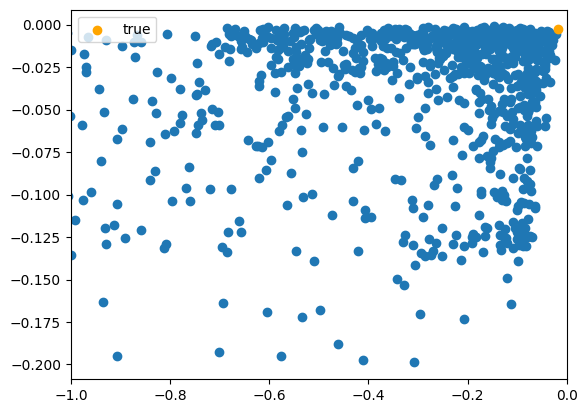

In [54]:
# Expectedly, space of training data after BO training should cover the neighborhood of true param simulation's discrepancy point (the orange point)
plt.scatter(train_Y[:,0],train_Y[:,1])
plt.scatter(real_dis[0][0],real_dis[0][1],color='orange',label='true')
plt.xlim(-1,0)
plt.legend(loc=2)
plt.show()

In [56]:
# The real parameter we target
real_theta_u = [real_theta[0],real_theta[3],real_theta[4],real_theta[6],real_theta[7],real_theta[8]]

In [57]:
# Test gp prediction
gp.posterior(torch.Tensor(real_theta_u).view(1,-1)).mean

tensor([[-0.0338, -0.0098]], dtype=torch.float64, grad_fn=<TransposeBackward0>)

In [58]:
gp.posterior(train_X[-1,:].view(1,-1)).mean

tensor([[-0.3919, -0.0371]], dtype=torch.float64, grad_fn=<TransposeBackward0>)

In [59]:
# Store gp prediction and likelihood
# Note that the botorchlikelihood here is not the ABC approximate likelihood illustarted in paper, this likelihood is maximized to infer predictive distribution
# No noise of data points involved here  
training_results = np.zeros((train_Y.size()[0], 6))

for i in range(train_Y.size()[0]):
    real_obj = train_Y[i,:]
    pred_obj = gp.posterior(train_X[i,:].view(1,-1)).mean
    pred_var = gp.posterior(train_X[i,:].view(1,-1)).variance
    botorchlikelihood1 = torch.distributions.Normal(loc=pred_obj[0][0], scale=pred_var[0][0]).log_prob(real_obj[0])
    botorchlikelihood2 = torch.distributions.Normal(loc=pred_obj[0][1], scale=pred_var[0][1]).log_prob(real_obj[1])
    botorchlikelihood = botorchlikelihood1+botorchlikelihood2
    training_results[i,:] = [i,real_obj[0].item(),real_obj[1].item(),pred_obj[0][0].item(),pred_obj[0][1].item(),botorchlikelihood.item()]

training_results

array([[ 0.00000000e+00, -2.04497910e-01, -1.50480390e-02,
        -2.00951035e-01, -1.69704870e-02, -1.53195806e+04],
       [ 1.00000000e+00, -9.20821007e-02, -1.50941004e-02,
        -9.22076370e-02, -1.62477816e-02, -1.13416335e+04],
       [ 2.00000000e+00, -5.62587120e-01, -2.46784931e-02,
        -5.61533136e-01, -2.84450788e-02, -1.24106900e+04],
       ...,
       [ 1.09800000e+03, -1.60364081e+00, -1.16623730e-01,
        -1.60427590e+00, -1.16174396e-01, -5.66160746e+01],
       [ 1.09900000e+03, -9.07049150e-01, -6.75622203e-02,
        -9.06451790e-01, -6.79623636e-02, -1.07540196e+02],
       [ 1.10000000e+03, -3.78074909e-01, -4.89324440e-02,
        -3.91855865e-01, -3.70619820e-02, -7.60910048e+04]])

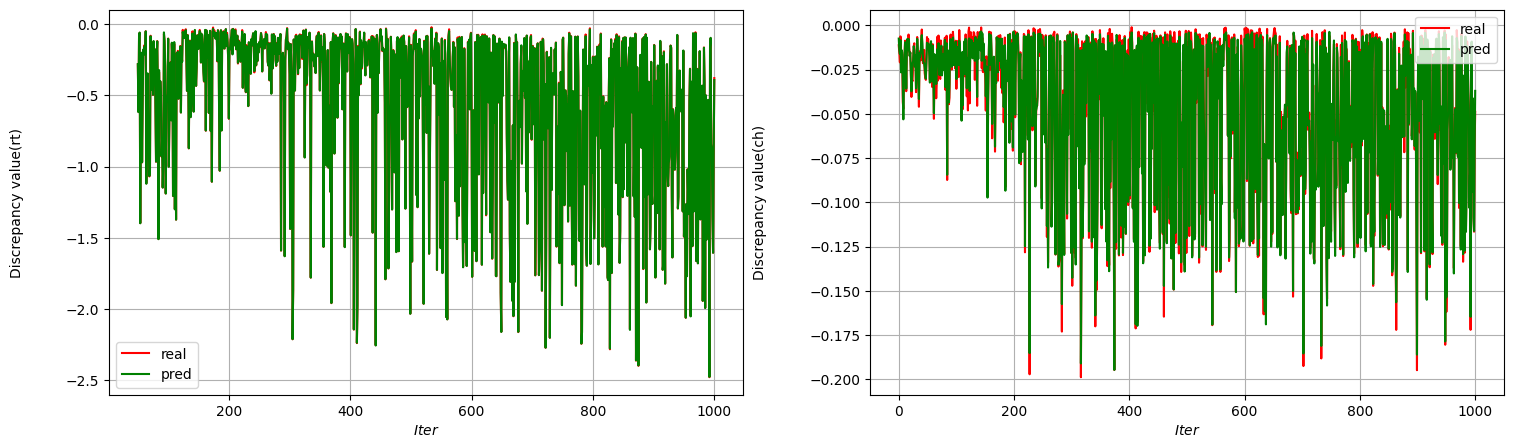

In [60]:
# Draw training curves
# Two curves should almost match together, menaing accurate prediction
font_size_text = 10
fs=10


fig, axs = plt.subplots(1, 2, figsize=(18,5))
axs[0].plot(training_results[num_init_samples+50:,0]-num_init_samples, training_results[num_init_samples+50:,1], color='red', label='real')
axs[0].plot(training_results[num_init_samples+50:,0]-num_init_samples, training_results[num_init_samples+50:,3],'green',label='pred',)
axs[0].legend(fontsize=fs)
axs[0].grid()
axs[0].tick_params(axis='both', labelsize=fs)
axs[0].set_xlabel(r'$Iter$',fontsize=font_size_text)
axs[0].set_ylabel(r'Discrepancy value(rt)',fontsize=font_size_text,rotation='vertical',labelpad=30)

axs[1].plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,2], color='red', label='real')
axs[1].plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,4],'green',label='pred')
axs[1].legend(loc=1,fontsize=fs)
axs[1].grid()
axs[1].tick_params(axis='both', labelsize=fs)
axs[1].set_xlabel(r'$Iter$',fontsize=font_size_text)
axs[1].set_ylabel(r'Discrepancy value(ch)',fontsize=font_size_text,rotation='vertical',labelpad=30)


plt.show()

In [61]:
# Estimate covaraince of noise term by simulating with input the latest candidate
Y_cov = np.zeros((200,number_of_discrepancies))
index = np.argmax(training_results[:,-1])
X_cov = train_X[index,:].flatten().numpy()
for i in range(200):
    Y_cov[i,:] = minus_simluated_discrepancy(theta = ([X_cov[0], real_theta[1]], real_theta[2],[X_cov[1],X_cov[2],real_theta[5]],
                                                    [X_cov[3],X_cov[4]], X_cov[-1]))

cov_est_noise = np.cov(Y_cov, rowvar = False)

In [62]:
cov_est_noise

array([[2.70567176e-05, 5.45104509e-08],
       [5.45104509e-08, 2.54715169e-06]])

In [64]:
# Optinal: estimate the correlation between output dimensions (rt and ch)
# Estimate the correlation separately by applying covariance formula ot train_Y
cov_est_output = np.cov(train_Y, rowvar = False)
cov_est_output

array([[0.28449176, 0.00775464],
       [0.00775464, 0.00196118]])

One thing worth to meantion is that the estimated covariance $Σ$, has small values. That suggest the 2 data courses (rt and ch) simulated by MLBA have noise uncorrelated from each other, i.e. the noise from 2 data sources come from 2 independent places.

As iteration goes, it is clear to see the predictive discrepancies values are decreasing and gradually going to the real data average, which is expected to see in theory.

But a good surrogate is not our ultimate target, we want "good" params that attain high likelihood values, and generate high similarity data, i.e. discrepancies very small.

So, the next step is to infer params and test their performance.

**Parameter inference and performance test**

After training the model, we need to compute the approximate posterior function. (See the original BOLFI paper)

Then, we need to draw MCMC sample parameters from the approximate posterior distribution. And draw plots of marginal posterior for each parameter.

Finally, we are going to test performance of parameter inference, by picking up a parameter point at high posterior density value, simluated multiple datasets given that parameter and present its similarity with real data.

In [65]:
# The approximate likelihood is viewed as approximate posterior now,
# theta : (1*number_of_parameters) parameter point
# The likelihood approximate here is approximating p(y_obs|theta)

tol = torch.quantile(train_Y,q=0.99,dim=0).tolist()# Test affect of quantile tol level on inference, change the value of q here
print(tol)


from scipy.stats import multivariate_normal

def approximate_log_likelihood(theta,tol=tol,cov_noise=cov_est_noise,gp=gp,covariance=0):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  means = means.view(-1).detach().numpy() * -1
  Sigma = np.array([[variances[0][0].item(),covariance],
                    [covariance,variances[0][1].item()]])
  cov_matrix = cov_noise + Sigma
  mulnorm = multivariate_normal(mean=means, cov=cov_matrix)
  log_likelihood = torch.Tensor([mulnorm.logcdf([-tol[0],-tol[1]])]).reshape(-1)
  return log_likelihood

[-0.03546041852605038, -0.002081343336886077]


In [66]:
approximate_log_likelihood(theta=train_X[-1,:].view(-1)) #Input is defined to be 1d tensor theta, which satisfies need of MCMC package

tensor([-138.5307])

In [67]:
approximate_log_likelihood(theta=torch.Tensor(real_theta_u).view(-1)) # should be large and larger than value of the chunk above

tensor([-6.0842])

In [68]:
real_theta_u 

[0.1, -22, -5, 3, 1.5, np.float64(4.59511985013459)]

In [69]:
#Test likelihood
lls = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    lls[i] = approximate_log_likelihood(param)

df_describe = pd.DataFrame(lls)
prior_median = df_describe.median()
df_describe.describe()

,0
count,1101.000000
mean,-inf
std,NaN
min,-inf
25%,NaN
50%,-391.489838
75%,-105.337296
max,-4.903133


The prior density is defined to be product of each marginal priors (assume parameters are indep).

In [70]:
def log_prior(theta):# theta is 1d tensor
    
    for i in range(theta.size()[0]):
        if theta[i]<=lows_u[i] or theta[i]>=highs_u[i]:
            return torch.Tensor([-1e12])[0]
    
    lp_log_lambda0 = torch.distributions.Uniform(low=lows_u[0], high=highs_u[0]).log_prob(theta[0])
    # lp_log_lambda1 = torch.distributions.Uniform(low=lows[1], high=highs[1]).log_prob(theta[1])
    # lp_log_I0 = torch.distributions.Uniform(low=lows[0], high=highs[0]).log_prob(theta[0])
    lp_beta1 = torch.distributions.Uniform(low=lows_u[1], high=highs_u[1]).log_prob(theta[1])
    lp_beta2 = torch.distributions.Uniform(low=lows_u[2], high=highs_u[2]).log_prob(theta[2])
    # lp_beta3 = torch.distributions.Uniform(low=lows[3], high=highs[3]).log_prob(theta[3])
    # delta1 = 0
    lp_delta2 = torch.distributions.Uniform(low=lows_u[3], high=highs_u[3]).log_prob(theta[3])
    lp_delta3 = torch.distributions.Uniform(low=lows_u[4], high=highs_u[4]).log_prob(theta[4])
    lp_log_threshold_A = torch.distributions.Uniform(low=lows_u[5], high=highs_u[5]).log_prob(theta[5])

    lp = (lp_log_lambda0+lp_beta1+lp_beta2+lp_delta2+lp_delta3+lp_log_threshold_A)
    
    
    return lp

In [71]:
log_prior(theta=train_X[-2,:].view(-1))

tensor(-9.7041)

In [72]:
log_prior(torch.tensor([item-0.5 for item in real_theta_u]).view(-1))

tensor(-1.0000e+12)

In [73]:
#Test prior
priors = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    priors[i] = log_prior(param)

df_describe = pd.DataFrame(priors)
prior_median = df_describe.median()
df_describe.describe()


,0
count,1.101000e+03
mean,-1.389646e+11
std,3.460668e+11
min,-1.000000e+12
25%,-9.704061e+00
50%,-9.704061e+00
75%,-9.704061e+00
max,-9.704061e+00


In [74]:
# Define approximate posterior
def approximate_log_posterior(theta):
  ll = approximate_log_likelihood(theta)
  lprior = log_prior(theta)
  lp = lprior + ll
  return lp

In [75]:
approximate_log_posterior(theta=torch.Tensor(real_theta_u).view(-1))

tensor([-15.7883])

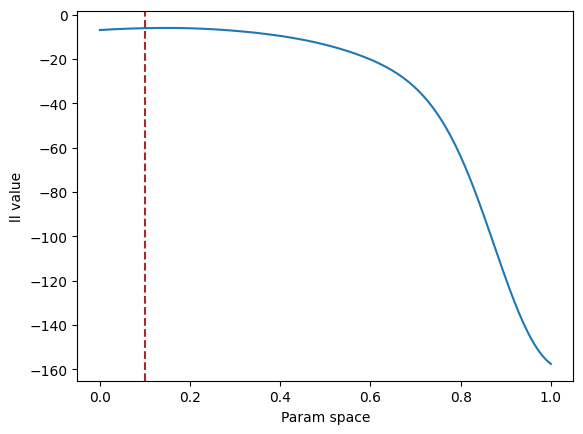

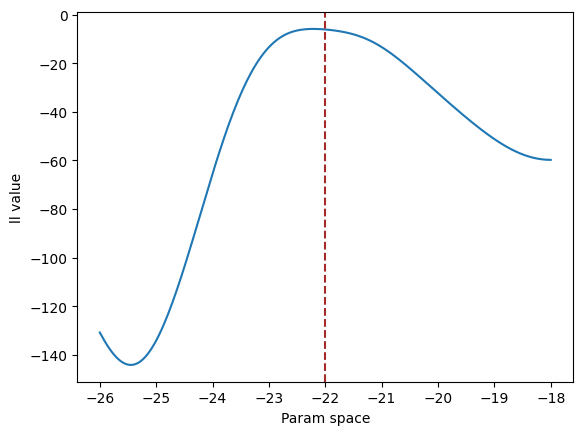

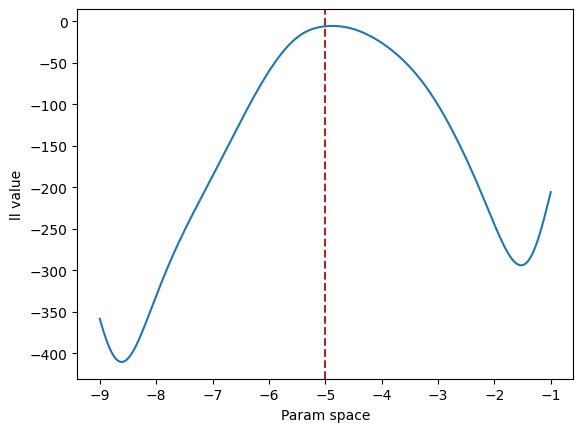

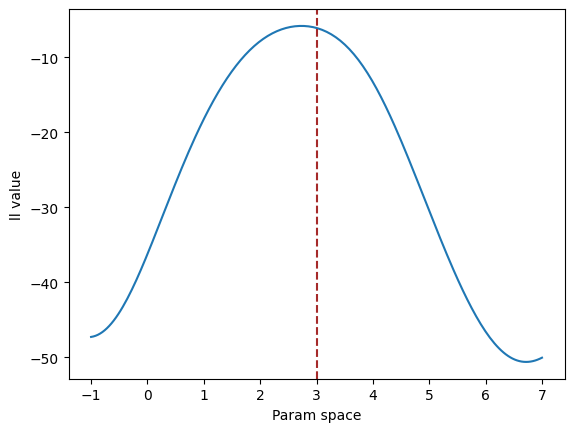

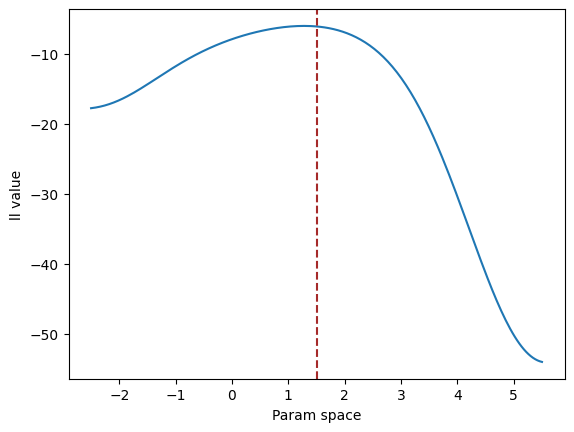

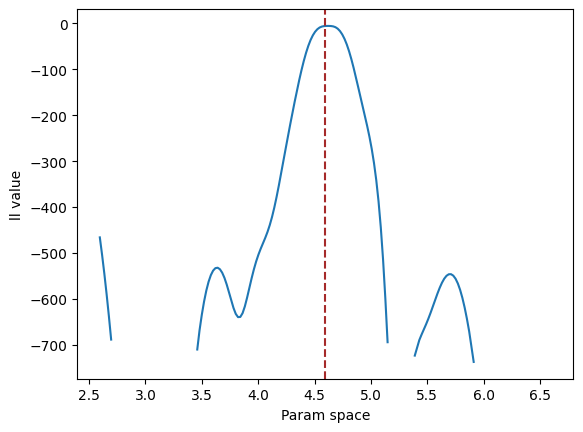

In [76]:
# Visualize the approximated log-lielihood for each parameter space
  
for param_index in range(num_of_parameters):
    shift_thetas = np.linspace(lows_u[param_index],highs_u[param_index], 200)
    shift_marlls = np.zeros(200)
    for i in range(200):
        tr_theta = list(real_theta_u)
        tr_theta[param_index] = shift_thetas[i]
        shift_marlls[i] = approximate_log_likelihood(torch.Tensor(tr_theta).view(-1)).item()
    
    plt.plot(shift_thetas,shift_marlls)
    plt.axvline(real_theta_u[param_index],0,200,linestyle="--",c='brown',label='$true$')
    plt.xlabel("Param space")
    plt.ylabel("ll value")
    plt.show()

In [78]:
# Marginal approximate likelihood of ch / rt data source

tol = torch.quantile(train_Y,q=0.95,dim=0).tolist()# Test quantile tol level vs marginal posterior, approx ll is very sensitive to tol level!
print(tol)

def approximate_log_likelihood_rt(theta,tol=tol,cov_noise=cov_est_noise,gp=gp):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  if torch.isnan(means[0][0]):
      return torch.from_numpy(np.array(-np.Inf).reshape(-1))
  means = means * -1
  item1 = (-tol[0]-means[0][0])/torch.sqrt(variances[0][0]+torch.Tensor(cov_noise)[0][0])
  prob1 = 0.5 * (1 + torch.erf(item1 / torch.sqrt(torch.tensor(2))))
  log_likelihood = torch.log(prob1)
  return log_likelihood

def approximate_log_likelihood_ch(theta,tol=tol,cov_noise=cov_est_noise,gp=gp):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  if torch.isnan(means[0][1]):
      return torch.from_numpy(np.array(-np.Inf).reshape(-1))
  means = means * -1
  item2 = (-tol[1]-means[0][1])/torch.sqrt(variances[0][1]+torch.Tensor(cov_noise)[1][1])
  prob2 = 0.5 * (1 + torch.erf(item2 / torch.sqrt(torch.tensor(2))))
  log_likelihood = torch.log(prob2)
  return log_likelihood

[-0.06304693884335426, -0.003814339345973804]


In [80]:
print(approximate_log_likelihood_rt(theta=train_X[-1,:].view(-1))) #Input is defined to be 1d tensor theta, which satisfies need of MCMC package
print(approximate_log_likelihood_rt(theta=torch.Tensor(real_theta_u).view(-1))) # should be large and larger than value of the chunk above

print(approximate_log_likelihood_ch(theta=train_X[-1,:].view(-1))) #Input is defined to be 1d tensor theta, which satisfies need of MCMC package
print(approximate_log_likelihood_ch(theta=torch.Tensor(real_theta_u).view(-1))) # should be large and larger than value of the chunk above


likelihoods_rt = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    likelihoods_rt[i] = approximate_log_likelihood_rt(param)

df_describe = pd.DataFrame(likelihoods_rt)
print(df_describe.describe())

likelihoods_ch = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    likelihoods_ch[i] = approximate_log_likelihood_ch(param)

df_describe = pd.DataFrame(likelihoods_ch)
print(df_describe.describe())


def approximate_log_posterior_rt(theta):
  ll = approximate_log_likelihood_rt(theta)
  lprior = log_prior(theta)
  lp = lprior + ll - prior_median.item()
  return lp

def approximate_log_posterior_ch(theta):
  ll = approximate_log_likelihood_ch(theta)
  lprior = log_prior(theta)
  lp = lprior + ll - prior_median.item()
  return lp

tensor(-inf, dtype=torch.float64, grad_fn=<LogBackward0>)
tensor(-2.0064e-05, dtype=torch.float64, grad_fn=<LogBackward0>)
tensor(-19.4302, dtype=torch.float64, grad_fn=<LogBackward0>)
tensor(-3.9528, dtype=torch.float64, grad_fn=<LogBackward0>)
                 0
count  1101.000000
mean          -inf
std            NaN
min           -inf
25%            NaN
50%            NaN
75%     -29.965438
max      -0.000003
                 0
count  1101.000000
mean          -inf
std            NaN
min           -inf
25%            NaN
50%     -13.564247
75%      -3.849346
max      -0.597466


DeMCMC

In [81]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import norm


class DEMCMC:

    def __init__(self, param_prior, param_hyper, post_fun, post_type,
                 param_num, chain_num, iter_num,
                 burn_in, migrate_rate, gamma, epsilon_b):
        """
        :param param_prior: a list of strings. list length should be the same as param_num.
                        Only two types prior distribution are available now.
                        "norm", for normal distribution prior.
                        "unif", for uniform distribution prior.
        :param param_hyper: a  (param_num,2) array. Entries are float type.
                        X[i,0] is the mean (or lower bound) of norm (uniform) distribution;
                        X[i,1] is the sd (or upper bound) of the norm (uniform) distribution;

        :param post_fun: a python function for posterior calculation

        :param post_type: bool type
                    post_type = 0, if the posterior returns from 0 to 1.
                    post_type = 1, if the posterior returns log-value.
        :param post_module: string
                    name of module contains the posterior function
        :param param_num: int type.
                    The number of estimable parameters. parameters with known fixed number were included.
        :param chain_num: int type.
                    The number of chains. When n<6,the chain_num = 24; otherwise, chain_num = 3*param_num.
        :param iter_num: int type.
                    The number of iteration.
        :param burn_in: int type.
                    The number of iteration for burn-in period. This part will discard for posterior sampling.
                    Moreover, migration step happens during burn-in period to facilitate convergence
        :param migrate_rate: float type. range from 0 to 1
                    The rate of migration step frequency during burn-in period.
        :param gamma: float type. A hyperparameter of De-MCMC crossover step. gamma = 2.38/sqrt(2*param_num)
        :param epsilon_b: float type. A hyperparameter of De-MCMC crossover step. epsilon \sim uniform[-epsilon_b,epsilon_b]
        """

        self.param_num = param_num
        self.chain_num = chain_num
        self.iter_num = iter_num
        self.burn_in = burn_in
        self.migrate_rate = migrate_rate
        self.gamma = gamma
        self.epsilon_b = epsilon_b
        self.param_prior = param_prior
        self.param_hyper = param_hyper
        self.postfun = post_fun
        self.post_type = post_type


    def log_poster(self, theta):
        """
        :param theta: a list. input of posterior function
        :return: float type. the log-posterior for the dataset given input theta
        """
        if self.post_type:
            # log-posterior is directly used.
            res = self.postfun(theta)
            if np.isnan(res):
                res = -np.inf
                print("Warning: A log-posterior input is NaN. The system will drop it.")
            elif res < -1e12:
                res = -np.inf
                print("The log-posterior input is less than -1e12.")
        else:
            # log-posterior is calculated.
            if np.isnan(self.postfun):
                print("Warning: A posterior input is NaN. The system will drop it.")
                res = -np.inf
            elif self.postfun < 1e-16:
                print("The posterior input is less than 1e-16.")
                res = -np.inf
            else:
                res = np.log(self.postfun(theta))

        return res

    def draw_prior(self, num, prior, hyper):
        '''
        return the random draw from prior
        :param num: int type. the number of random samples.
        :param prior: a string,either "norm" or "unif"
        :param hyper: array(1,2).
                    hyper[0] = mean of norm distribution (or lower bound of uniform);
                    hyper[1] = sd of norm distribution (or upper bound of uniform);
        :return: an array (num,1).
        '''
        if prior == "norm":
            res = np.random.normal(loc=hyper[0], scale=hyper[1], size=num)
        elif prior == "unif":
            res = np.random.uniform(low=hyper[0], high=hyper[1], size=num)
        else:
            print("error: the prior shape is unkown.")
            res = np.nan

        return res


    def initial_chains(self):
        """
        A function to return  for initial value
          :return: a list, whose first and only element is a (chain_num, param_num) matrix
        """
        # Initialize chains. The last column is for likelihood

        chain_list = []
        # check input
        if (len(self.param_prior) != self.param_num) | (np.shape(self.param_hyper)[0] != self.param_num):
            print("error: The parameter prior or hyper input length is inconsistent with parameter number.")
        elif np.shape(self.param_hyper)[1] != 2:
            print("error: The dimension of hyperparameters are inconsistent with design, ",
                  "please check `inital_chains` function for details.")
        else:
            theta_0 = np.zeros((self.chain_num, self.param_num + 1))

            for i in range(self.param_num):
                theta_0[:, i] = self.draw_prior(self.chain_num, self.param_prior[i], self.param_hyper[i, :]).tolist()
            # calculate the log-posterior for chain_num parameter sets
            theta_0[:, self.param_num] = np.apply_along_axis(lambda x: self.log_poster(x[:-1]), 1, theta_0).reshape(self.chain_num, )
            # make sure all initial value has a valid posterior.
            index_p = np.where(np.isinf(theta_0[:, self.param_num]), range(self.chain_num), [-1]*self.chain_num)
            index = []
            for j in index_p:
                if j>=0:
                    index.append(j)

            while len(index) > 0:
                for i in range(self.param_num):
                    theta_0[index, i] = self.draw_prior(len(index), self.param_prior[i], self.param_hyper[i, :]).tolist()
                theta_0[index, self.param_num] = np.apply_along_axis(lambda x: self.log_poster(x[:-1]), 1,
                                                                theta_0[index]).reshape(len(index), )
                index_p = np.where(np.isinf(theta_0[:, self.param_num]), range(self.chain_num), [-1]*self.chain_num)
                index = []
                for j in index_p:
                    if j >= 0:
                        index.append(j)
            chain_list.append(pd.DataFrame(theta_0))

        return chain_list


    def crossover_step(self, chain_index, last_step_chains):
        """
        For a given chain, randomly draw other two chains to get the difference value, the proposed value = chain_value + difference + epsilon
        :param chain_index: int type. The index of the updated chain at this step
        :param last_step_chains: A dataframe.
        :return: the value of chain of this step.It is a vector whose length is param_num+1.

        """
        # last_step_chains = chain_list[last_step_index]
        # get the previous parameter values in this chain
        theta_prev = np.array(last_step_chains.iloc[chain_index, :-1])
        # Randomly draw two chain indices from all chains except the current chain
        prob = [1 / (self.chain_num - 1)] * self.chain_num
        prob[chain_index] = 0
        de_ChainIndex = np.random.choice(range(self.chain_num), size=2, replace=False, p=prob)

        theta_m = np.array(last_step_chains.iloc[de_ChainIndex[0], :-1])
        theta_n = np.array(last_step_chains.iloc[de_ChainIndex[1], :-1])

        # Generate new theta; here, there are npar parameters to estimate in total
        epsilon = np.random.uniform(-self.epsilon_b, self.epsilon_b, self.param_num)
        theta_proposed = theta_prev + self.gamma * (theta_m - theta_n) + epsilon

        proposed_post = self.log_poster(theta_proposed)
        if np.isnan(proposed_post):  # avoid nan.
            proposed_post = -np.inf
        prev_post = last_step_chains.iloc[chain_index, self.param_num]

        # Acceptance rate
        alpha = np.random.uniform()
        ratio = proposed_post - prev_post
        if np.isnan(ratio):
            print("Warning: please check the initial matrix.")
            ratio = -1
        elif np.isinf(ratio) | (ratio <= -1e12):
            ratio = -1
        else:
            ratio = np.exp(ratio)
        if alpha > ratio:
            # reject the proposed value
            temp = np.append(theta_prev, prev_post)

        else:
            temp = np.append(theta_proposed, proposed_post)

        return temp



    def migration_step(self, last_step_chains):

        """
        migration step is optional for De-MCMC, but very useful for the convergence.
        Normally, every 10 or 5 crossover steps during the burn-in stage, one migration step can be used.
        :param last_step_chains: A chain_num by (param_num +1) Dataframe.
         :return: A Dataframe, whose dimension is chain_num by (param_num +1). The last column is log-posterior value.
        """
        temp = last_step_chains
        # select the migration scale, from 2 to chain_num
        mig_num = np.random.randint(low=1, high=self.chain_num)+1
        # randomly draw mig_num chains for migration.
        mig_index = np.random.choice(range(self.chain_num), size=mig_num, replace=False)

        prev_theta = np.array(temp.iloc[mig_index, :-1])
        prev_post = temp.iloc[mig_index, -1].tolist()
        epsilon = np.random.uniform(low=-self.epsilon_b, high=self.epsilon_b, size=(mig_num, self.param_num))

        for i in range(mig_num):
            if i != (mig_num - 1):  # not the last item
                proposed_theta = prev_theta[(i + 1), :] + epsilon[i, :]
            else:
                proposed_theta = prev_theta[0, :] + epsilon[i, :]

            proposed_post = self.log_poster(proposed_theta)
            if np.isnan(proposed_post):  # aviod nan.
                proposed_post = -np.inf
            # whether to accept
            alpha = np.random.uniform()
            ratio = proposed_post - prev_post[i]
            if np.isnan(ratio):
                print("Warning: please check the initial matrix.")
                ratio = -1
            elif np.isinf(ratio) | (ratio <= -1e12):
                ratio = -1
            else:
                ratio = np.exp(ratio)

            if alpha < ratio:  # accept the proposed value
                temp.iloc[mig_index[i], :] = np.append(proposed_theta, proposed_post)
            else:
                temp.iloc[mig_index[i], :] = np.append(prev_theta[i, :], prev_post[i])

        return temp

    def De_MCMC(self) -> list:
        """
        This functions to for De-MCMC sampling to return a chain trace list.
       :return: A list with (iter_num+1) elements, each element is a Dataframe has chain_num rows and param_num+1 columns.
        """
        # initial chain_list
        chain_list = self.initial_chains()
        print("initialization is finished.")

        chain_add = chain_list[0]
        chain_add1 = chain_add
        for i in range(self.iter_num):
            chain_add = pd.DataFrame(Parallel(n_jobs=-3)(delayed(self.crossover_step)(row, chain_add) for row in range(self.chain_num)))
            # for j in range(self.chain_num):
            #     chain_add1.iloc[j, :] = self.crossover_step(chain_index=j, last_step_chains=chain_add)
            # chain_add = chain_add1

            if i%50 == 0:
                print(i, "iterations has been done.")
            chain_list.append(chain_add)
            if (i <= self.burn_in) & (np.random.uniform() < self.migrate_rate):
                # conduct migrate step
                chain_add = self.migration_step(chain_add)
                chain_list[i + 1] = chain_add
        return chain_list

In [83]:
# DEMCMC sampling
if __name__ == "__main__":
    param_num = 6
    chain_num = 9 # This is just a simple example, normally the chain_num is 3*param_num
    iter_num = 8000
    burn_in = 3000
    migrate_rate = 0.5 # 0.3 - 0.7
    gamma = 2.38 / np.sqrt(2 * param_num)  # suggested value
    epsilon_b = 1e-4
    param_prior = ["unif", "unif", "unif", "unif", "unif", "unif"]
    param_hyper = np.array([[lows_u[0], highs_u[0]], [lows_u[1], highs_u[1]],[lows_u[2], highs_u[2]], [lows_u[3], highs_u[3]], [lows_u[4], highs_u[4]],
                            [lows_u[5]+0.1, highs_u[5]-0.1]])
    
    def myll(theta):
        theta = torch.tensor(theta).view(-1)
        ll = approximate_log_posterior(theta)
        return ll.item()

    test_list = DEMCMC(param_prior=param_prior, param_hyper=param_hyper,
                  post_fun=myll, post_type=1,
                  chain_num=chain_num, param_num=param_num, iter_num=iter_num,
                  burn_in=burn_in, migrate_rate=migrate_rate, gamma=gamma, epsilon_b=epsilon_b)

    demcmc_sample_list_full = test_list.De_MCMC()
    
    print(demcmc_sample_list_full)

The log-posterior input is less than -1e12.
The log-posterior input is less than -1e12.
The log-posterior input is less than -1e12.
The log-posterior input is less than -1e12.
The log-posterior input is less than -1e12.
The log-posterior input is less than -1e12.
The log-posterior input is less than -1e12.
initialization is finished.
0 iterations has been done.
50 iterations has been done.
100 iterations has been done.
150 iterations has been done.
200 iterations has been done.
250 iterations has been done.
300 iterations has been done.
350 iterations has been done.
400 iterations has been done.
450 iterations has been done.
500 iterations has been done.
550 iterations has been done.
600 iterations has been done.
650 iterations has been done.
700 iterations has been done.
750 iterations has been done.
800 iterations has been done.
850 iterations has been done.
900 iterations has been done.
950 iterations has been done.
1000 iterations has been done.
1050 iterations has been done.
1100 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [84]:
# Save the demcmc sample list for MOBOLFI AUX
import pickle
with open("demcmc_sample_list_full_AUX_Repro_Weight", "wb") as fp:   #Pickling
    pickle.dump(demcmc_sample_list_full, fp)

In [85]:
# Demcmc sample for MOBOLFI AUX
# option: flatten over chains
param_num = 6
chain_num = 9 # This is just a simple example, normally the chain_num is 3*param_num
iter_num = 8000
burn_in = 3000
migrate_rate = 0.5 # 0.3 - 0.7
gamma = 2.38 / np.sqrt(2 * param_num)  # suggested value
epsilon_b = 1e-4
param_prior = ["unif", "unif", "unif", "unif", "unif", "unif"]
param_hyper = np.array([[lows_u[0], highs_u[0]], [lows_u[1], highs_u[1]],[lows_u[2], highs_u[2]], [lows_u[3], highs_u[3]], [lows_u[4], highs_u[4]],
                        [lows_u[5]+0.1, highs_u[5]-0.1]])

coords_demcmc = np.zeros((1, num_of_parameters))

for i in range(burn_in,len(demcmc_sample_list_full)-1):
    sample = demcmc_sample_list_full[i].iloc[:,:-1]
    coords_demcmc = np.concatenate((coords_demcmc,sample),axis=0)

In [86]:
# Load the estimation results of closed-form likelihood (MLBA)
coords_demcmc_mlbathetas = pd.read_csv('closedformllk_mlba.txt', sep=' ', header=None)
coords_demcmc_mlbathetas.head()
coords_demcmc_mlbathetas = np.array(coords_demcmc_mlbathetas)

In [88]:
# Load the estimation results of MOBOLFI
coords_demcmc_ORI = pd.read_csv('mobolfi_1000iter_1quantiletol_demcmcsample.txt', sep=' ', header=None)
coords_demcmc_ORI.head()
coords_demcmc_ORI = np.array(coords_demcmc_ORI)

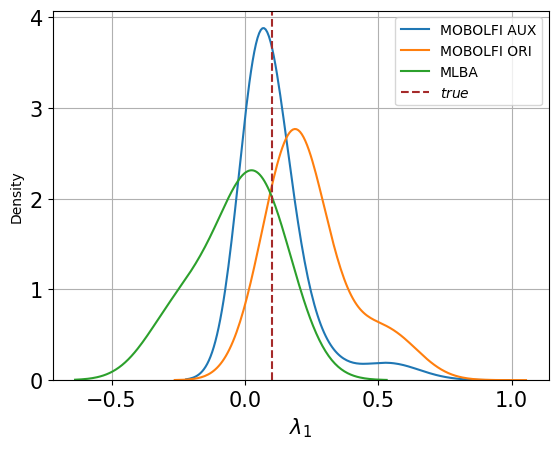

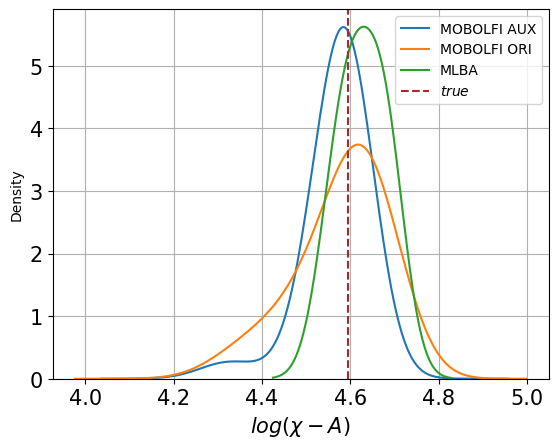

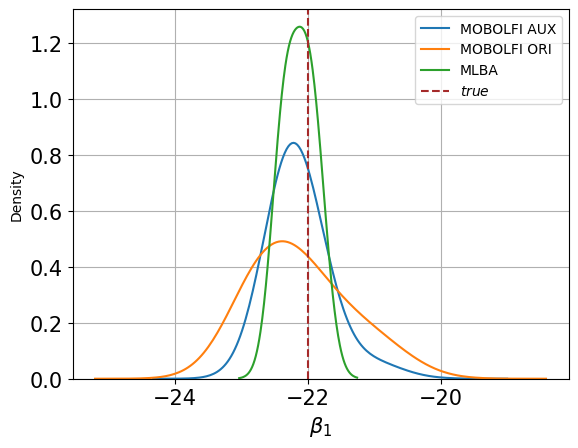

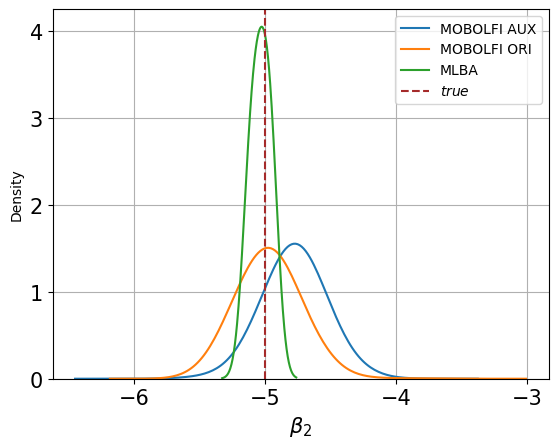

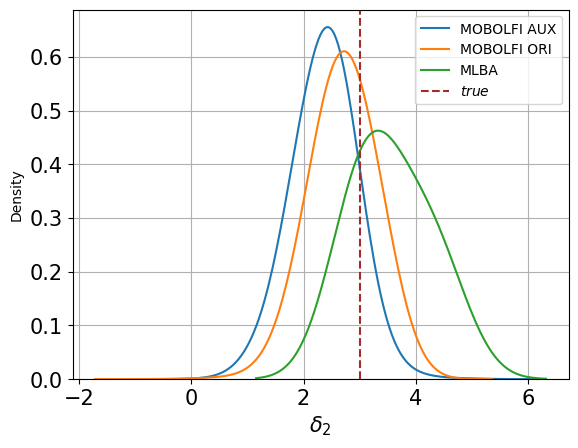

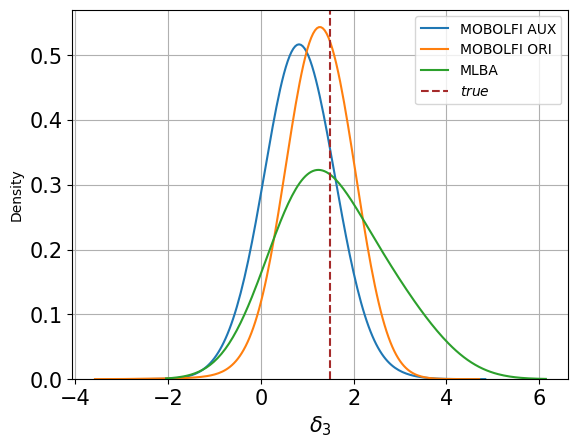

In [90]:
# Draw a Figue 6 in the Supplementary comparing approximate posteriors of MLBA example estimated by different data summary for response choice.
from plotly.io import write_image
import plotly.tools as tls
import seaborn as sns

font_size_text = 15
fs=15

coords_demcmc_mobolfi = np.loadtxt('mobolfi_1000iter_1quantiletol_demcmcsample.txt', dtype=np.dtype('float64'))
coords_demcmc_mlbathetas = np.loadtxt('closedformllk_mlba.txt', dtype=np.dtype('float64'))

param_list = ['$\lambda_1$','$log (\chi-A)$',r'$\beta_1$',r'$\beta_2$','$\delta_2$','$\delta_3$']
mobolfi_llk_index = [0,5,1,2,3,4]
bwadjust_list = [25,70,70,110,25,25]
# closed_llk_index = [6,8,0,1,3,4]


for i in range(num_of_parameters):

    # Define the figure
    # fig = plt.figure()

    sns.kdeplot(coords_demcmc[1:,mobolfi_llk_index[i]], label='MOBOLFI AUX',bw_adjust=5)
    sns.kdeplot(coords_demcmc_mobolfi[1:,mobolfi_llk_index[i]], label='MOBOLFI ORI',bw_adjust=5)
    sns.kdeplot(coords_demcmc_mlbathetas[1:,mobolfi_llk_index[i]], label='MLBA',bw_adjust=5)
    plt.axvline(real_theta_u[mobolfi_llk_index[i]],0,1,linestyle="--",c='brown',label='$true$')
    plt.legend(fontsize=fs-5)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    plt.savefig('Type1_'+str(i)+'_AUX_Repro_Weight.png', dpi=300, bbox_inches='tight')
    plt.show()